In [2]:
from intermine.webservice import Service
import numpy as np
import scipy.io
import seaborn as sns
from scipy import stats, optimize, interpolate
import pandas as pd
from collections import defaultdict 
import math
import matplotlib.pyplot as plt
from scipy.stats import norm, lognorm
from scipy import stats
import matplotlib.cm as cm
import matplotlib.mlab as mlab
import os, fnmatch





In [3]:
## Collecting data

## curated data set on interactions in budding yeast SGD downloads
data_raw_interact=pd.read_excel(r'C:\Users\linigodelacruz\Documents\PhD_2018\Documentation\Calculations\data_sgd\interaction-filtered-data.xlsx',header=0,encoding="utf-8-sig")
##curated data on slim go terms in budding yeast SGD downloads
data_raw_slim_go=pd.read_excel(r'C:\Users\linigodelacruz\Documents\PhD_2018\Documentation\Calculations\data_sgd\slim-goterms-filtered-data.xlsx',header=0,encoding="utf-8-sig")

## published data from sgd from constanzo SGA 2010
data_int_score=pd.read_excel(r'C:\Users\linigodelacruz\Documents\PhD_2018\Documentation\Calculations\SGA-Boone-LAB\Costanzo2010-StringentCutoff.tab\genetic-interaction-score-dataset-constanzo.xlsx',header=4,encoding="utf-8-sig")

## published data in the cellmap.org 2016 
data_fitness_sga=pd.read_excel(r'C:\Users\linigodelacruz\Documents\PhD_2018\Documentation\Calculations\SGA-Boone-LAB\Data File S1. Raw genetic interaction datasets_ Pair-wise interaction format\Data-fitness.xlsx',header=0,sheet_name='NxN')

#essential genes in WT
annotated_essentials=pd.read_excel(r'C:\Users\linigodelacruz\Documents\PhD_2018\Documentation\Calculations\Esssential-genes-cerevisae\Essential-genes-yeast.xlsx',header=0,encoding="utf-8-sig")


In [136]:
## In case is necessary to make a new query , a new data retrieval to yeastmine where is the most updated info about genetic interactions 
# This is an example to search the synthetic lethals of bem1,bem3,bem2 and nrp1
service = Service('https://yeastmine.yeastgenome.org/yeastmine/service', token = '11d7t1Y007Fa97c82f27')

# Get a new query on the class (table) you will be querying:
query = service.new_query("Gene")

# The view specifies the output columns
query.add_view(
    "secondaryIdentifier", "symbol", "interactions.details.relationshipType",
    "interactions.participant2.symbol", "interactions.details.annotationType",
    "interactions.details.experiment.name"
)

# You can edit the constraint values below
query.add_constraint("Gene", "IN", "Target-genes-list", code = "A")
query.add_constraint("interactions.details.experiment.name", "CONTAINS", "Synthetic Lethality", code = "B")


data_toy=defaultdict(dict)

for row,counter in zip(query.rows(),np.arange(0,len(query.rows()))):
    data_toy['name'][counter]=row['symbol']
    data_toy['interactor'][counter]=row["interactions.participant2.symbol"]
    data_toy['type'][counter]=row["interactions.details.relationshipType"]
    data_toy['annotation'][counter]=row["interactions.details.annotationType"]
    data_toy['experiment'][counter]=row["interactions.details.experiment.name"]

data_toy_pd=pd.DataFrame(data_toy)
data_toy_pd




,name,interactor,type,annotation,experiment
0,BEM1,ARC40,genetic,high-throughput,"Tong AH, et al. (2001)-11743205-Synthetic Leth..."
1,BEM1,ARC40,genetic,high-throughput,"Tong AH, et al. (2004)-14764870-Synthetic Leth..."
2,BEM1,ARP2,genetic,high-throughput,"Tong AH, et al. (2001)-11743205-Synthetic Leth..."
3,BEM1,ARP2,genetic,high-throughput,"Tong AH, et al. (2004)-14764870-Synthetic Leth..."
4,BEM1,BBC1,genetic,high-throughput,"Tong AH, et al. (2001)-11743205-Synthetic Leth..."
...,...,...,...,...,...
111,BEM2,TUB2,genetic,high-throughput,"Parsons AB, et al. (2004)-14661025-Synthetic L..."
112,BEM2,YNG2,genetic,high-throughput,"Lin YY, et al. (2008)-18676811-Synthetic Letha..."
113,BEM2,YNG2,genetic,manually curated,"Lin YY, et al. (2008)-18676811-Synthetic Letha..."
114,BEM3,CDC24,genetic,manually curated,"Knaus M, et al. (2007)-17914457-Synthetic Leth..."


In [4]:
## Changin columns names

data_raw_interact.columns=['Gene', 'Interactor', 'Assay', 'Annotation', 'Notes','Phenotype','Reference-SGD','citation']


data_raw_slim_go.columns=['Gene','gene-id','go-aspect','go-term','go-id','feature-type' ]

data_int_score.columns=['query-orf','query-name','array-orf','array-name','score','std','p-value']

data_fitness_sga.columns=['query-strain','query-allele-name','array-strain','array-allele-name','array-type','score','p-value',
                           'query-fitness','array-fitness','double-fitness','double-fitness-std']
annotated_essentials.columns=['Gene','Organism','Condition','Function']




In [233]:
## Relating the synthetic data from the retrieve and the fitness data of non essential genes to see their scores 

genes_synt_bem1=data_toy_pd[data_toy_pd['name']=='BEM1']['interactor'].tolist()
genes_synt_bem1=np.unique(genes_synt_bem1)

fit_bem1=data_fitness_sga[data_fitness_sga['query-allele-name']=='bem1']

score_synt=defaultdict(dict)

for i in np.arange(0,len(genes_synt_bem1)):

    a=fit_bem1[fit_bem1['array-allele-name']==genes_synt_bem1[i].casefold()]
    if len(a)==0:
        score_synt['score'][genes_synt_bem1[i]]=0
        score_synt['p-value'][genes_synt_bem1[i]]=0
        score_synt['double-fitness'][genes_synt_bem1[i]]=0
        score_synt['array-fitness'][genes_synt_bem1[i]]=0
        score_synt['query-fitness'][genes_synt_bem1[i]]=0
    else:
        score_synt['score'][genes_synt_bem1[i]]=a.iloc[0,5]
        score_synt['p-value'][genes_synt_bem1[i]]=a.iloc[0,6]
        score_synt['double-fitness'][genes_synt_bem1[i]]=a.iloc[0,9]
        score_synt['array-fitness'][genes_synt_bem1[i]]=a.iloc[0,8]
        score_synt['query-fitness'][genes_synt_bem1[i]]=a.iloc[0,7]
    


score_synt_pd=pd.DataFrame(score_synt)
score_synt_pd.loc['HSP82','array-fitness']=0
score_synt_pd.loc['SMY1','array-fitness']=0
score_synt_pd

,score,p-value,double-fitness,array-fitness,query-fitness
ARC40,0.0000,0.000000e+00,0.0000,0.0000,0.0000
ARP2,0.0000,0.000000e+00,0.0000,0.0000,0.0000
BBC1,-0.5153,0.000000e+00,0.0931,0.9905,0.6143
BEM2,-0.0358,2.793000e+02,0.4698,0.8230,0.6143
BEM4,-0.2027,7.034000e-12,0.3039,0.8247,0.6143
BIM1,0.0000,0.000000e+00,0.0000,0.0000,0.0000
BNI1,0.0000,0.000000e+00,0.0000,0.0000,0.0000
BUB3,0.1067,4.754000e-10,0.5336,0.6950,0.6143
CDC24,0.0000,0.000000e+00,0.0000,0.0000,0.0000
CDC42,0.0000,0.000000e+00,0.0000,0.0000,0.0000


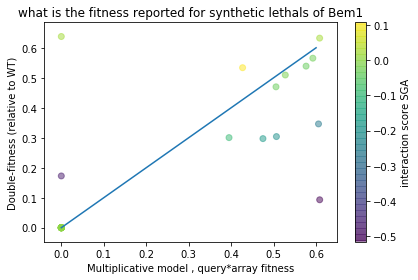

In [255]:
#plt.scatter(score_synt_pd['score'],score_synt_pd['double-fitness'])
plt.scatter(score_synt_pd['query-fitness']*score_synt_pd['array-fitness'],score_synt_pd['double-fitness'],alpha=0.5, c=score_synt_pd['score'])
plt.plot(np.linspace(0,0.6),np.linspace(0,0.6))
plt.xlabel('Multiplicative model , query*array fitness')
plt.ylabel('Double-fitness (relative to WT)')
plt.title('what is the fitness reported for synthetic lethals of Bem1')
plt.colorbar(label='interaction score SGA')
plt.tight_layout()

plt.savefig('multiplicative-vs-double-fitness-bem1.png',format='png',dpi=300,transparent=True)

In [5]:
def get_data(gene_name):
    data=data_fitness_sga[data_fitness_sga['query-allele-name']==gene_name]
    if len(data)==0:
        data=data_fitness_sga[data_fitness_sga['array-allele-name']==gene_name]
    for i in np.arange(0,len(data.iloc[:,8])):
        if data.iloc[i,8] > 1 or data.iloc[i,7] > 1 or data.iloc[i,9] >1 :
            data.iloc[i,8]=0
            data.iloc[i,7]=0
            data.iloc[i,9]=0

    return data





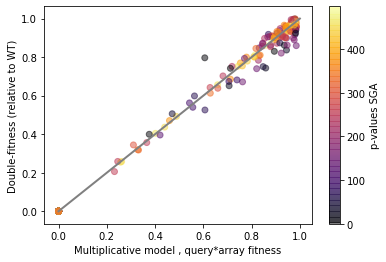

In [38]:
data=get_data('bem3')
#data=data[data.iloc[:,6]<1] # cutoff for the p-values

plt.scatter(data.iloc[:,8]*data.iloc[:,7],data.iloc[:,9],alpha=0.5, c=data.iloc[:,6],cmap='inferno')
plt.plot(np.linspace(0,1),np.linspace(0,1),linewidth=2,color='gray')
plt.colorbar(label='p-values SGA')
plt.xlabel('Multiplicative model , query*array fitness')
plt.ylabel('Double-fitness (relative to WT)')
plt.savefig('bem3-p-value-colormap.png',format='png',dpi=300,transparent=True)

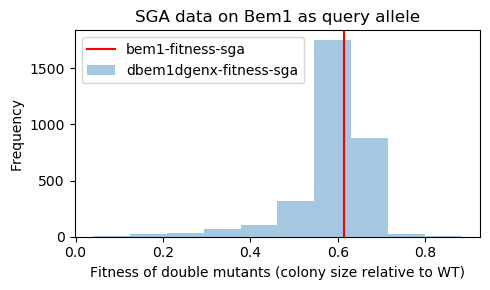

In [123]:
fig, axes = plt.subplots(1, 1, figsize=(5,3), dpi=100, sharex=True, sharey=True)
#plt.subplots_adjust(bottom=0.2, right=0.5, top=1.4)
#fig.suptitle('SGA data on Bem1 as query allele',x=0.5,y=1.05)


data_fitness_sga[data_fitness_sga['query-allele-name']=='bem1']['double-fitness'].plot(kind='hist',label='dbem1dgenx-fitness-sga',alpha=0.4)
# data_fitness_sga[data_fitness_sga['query-allele-name']=='bem1']['double-fitness-std'].plot(kind='hist',label='dbem1dgenx-fitness-sga-std')
bem1_data=data_fitness_sga[data_fitness_sga['query-allele-name']=='bem1']

plt.axvline(bem1_data['query-fitness'].tolist()[0],color='red',label='bem1-fitness-sga')
plt.legend()
plt.title('SGA data on Bem1 as query allele')
plt.xlabel('Fitness of double mutants (colony size relative to WT)')
# plt.plot(bem1_data['array-allele-name'][0:20],bem1_data['double-fitness'][0:20]),
# plt.plot(bem1_data['array-allele-name'][0:20],bem1_data['score'][0:20]),
plt.tight_layout()
#plt.savefig('double-mutant-fitness-BEM1-query-SGA.png',format='png',dpi=300,transparent=True)

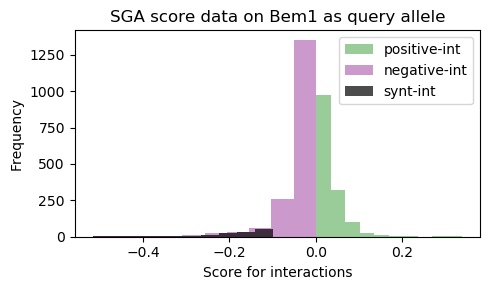

In [125]:
fig, axes = plt.subplots(1, 1, figsize=(5,3), dpi=100, sharex=True, sharey=True)
#plt.subplots_adjust(bottom=0.2, right=0.5, top=1.4)
#fig.suptitle('SGA data on Bem1 as query allele',x=0.5,y=1.05)


#data_fitness_sga[data_fitness_sga['query-allele-name']=='bem1']['score'].plot(kind='hist',label='dbem1dgenx-score-sga',alpha=0.4)
# data_fitness_sga[data_fitness_sga['query-allele-name']=='bem1']['double-fitness-std'].plot(kind='hist',label='dbem1dgenx-fitness-sga-std')
positive_score=data_fitness_sga[data_fitness_sga['query-allele-name']=='bem1']['score']>0
data_fitness_sga[data_fitness_sga['query-allele-name']=='bem1']['score'][positive_score[positive_score==True].index].plot(kind='hist',color='green', alpha=0.4,label='positive-int')

negative_score=data_fitness_sga[data_fitness_sga['query-allele-name']=='bem1']['score']<0
data_fitness_sga[data_fitness_sga['query-allele-name']=='bem1']['score'][negative_score[negative_score==True].index].plot(kind='hist',color='purple', alpha=0.4,label='negative-int')


negative_score=data_fitness_sga[data_fitness_sga['query-allele-name']=='bem1']['score']< -0.1
data_fitness_sga[data_fitness_sga['query-allele-name']=='bem1']['score'][negative_score[negative_score==True].index].plot(kind='hist',color='black', alpha=0.7,label='synt-int')

plt.legend()
plt.title('SGA score data on Bem1 as query allele')
plt.xlabel('Score for interactions')
plt.tight_layout()

plt.tight_layout()
plt.savefig('score-of-interactors-BEM1-query-SGA.png',format='png',dpi=300,transparent=True)